In [1]:
# Data visualization
import matplotlib.pyplot as plt
import cartopy

# Data manipulation
import pandas as pd
import numpy as np
import xarray as xr

# todo: mount GPU on colab.

In [2]:
repo_root = '../' # use 'climate-emulator-tutorial/' on colab and '../' on local machine
data_root = repo_root + 'data/'

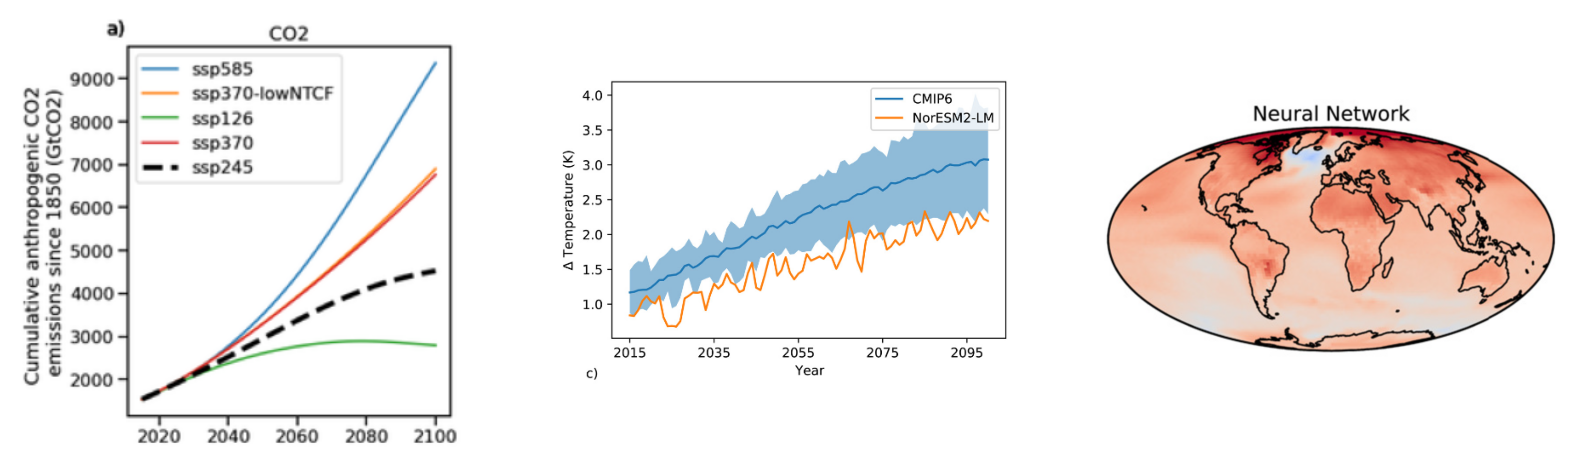

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import math

images = []
images.append(repo_root+'figures/tutorial/co2_over_time_per_scenario_climatebench.png')
images.append(repo_root+'figures/tutorial/global_t_over_time_in_ssp245.png')
images.append(repo_root+'figures/tutorial/t_over_space_avg_2080_2100_ssp245.png')

plt.figure(figsize=(20,10))
columns = 3
for i, image in enumerate(images):
    plt.subplot(math.ceil(len(images) / columns), columns, i + 1)
    im = Image.open(image)
    plt.imshow(im)
    plt.axis('off')

In [4]:
#@title code: load ClimateBench data
from emcli.data.climatebench import load_climatebench_train_data

scenarios = ['ssp126','ssp370','ssp585','hist-GHG','hist-aer']
len_historical = 165
data_path = data_root + '/'

X_train, Y_train = load_climatebench_train_data(
  simus=scenarios, len_historical=len_historical, 
  data_path=data_path)


Frozen({'time': 251, 'longitude': 144, 'latitude': 96}) ssp126
Frozen({'time': 251, 'longitude': 144, 'latitude': 96}) ssp370
Frozen({'time': 251, 'longitude': 144, 'latitude': 96}) ssp585
Frozen({'time': 165, 'longitude': 144, 'latitude': 96}) hist-GHG
Frozen({'time': 165, 'longitude': 144, 'latitude': 96}) hist-aer


In [5]:
print('Number of training scenarios:', len(X_train))
print('Inputs:')
print('\tInput channels:', ', '.join(list(X_train[0].data_vars)))
print(f'\tThe scenarios have {X_train[0]["CO2"].shape} time steps in (ssp) scenarios and {X_train[3]["CO2"].shape} in (historical).')
print(f'\tCO2 and CH4 are global [{X_train[0]["CO2"].shape}, {X_train[0]["CH4"].shape}], while SO2 and BC are spatially resolved [{X_train[0]["SO2"].shape}, {X_train[0]["BC"].shape}].')
print('Outputs:')
print('\tOutput channels:', ', '.join(list(Y_train[0].data_vars)))
print(f'\tAll outputs are spatially resolved: {Y_train[0]["tas"].shape} (ssp) or {Y_train[3]["tas"].shape} (historical).')

Number of training scenarios: 5
Inputs:
	Input channels: CO2, SO2, CH4, BC
	The scenarios have (251,) time steps in (ssp) scenarios and (165,) in (historical).
	CO2 and CH4 are global [(251,), (251,)], while SO2 and BC are spatially resolved [(251, 96, 144), (251, 96, 144)].
Outputs:
	Output channels: diurnal_temperature_range, tas, pr, pr90
	All outputs are spatially resolved: (251, 96, 144) (ssp) or (165, 96, 144) (historical).


### The global cumulative CO2 emissions and temperature anomaly correlate approximately linear on a 10yr time-scale.

- Linear assumption breaks down in aerosol-only experiment (hist-AER)
- The NorESM2 model underestimates warming in 1960-2010

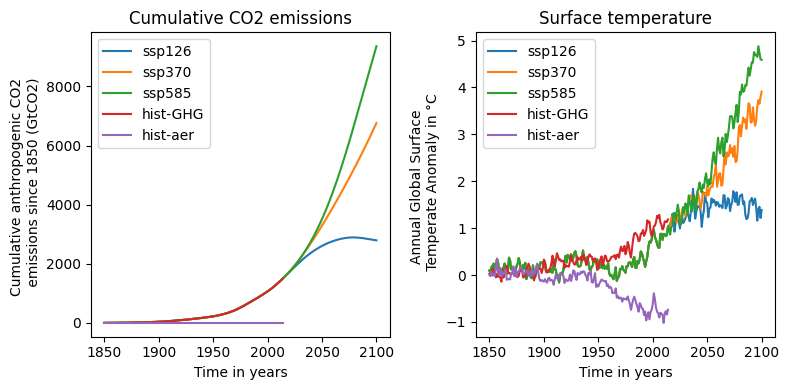

In [23]:
fig, axs = plt.subplots(1,2, figsize =(8,4))

# Plot global cumulative CO2 emissions over time
for idx, scenario in enumerate(('ssp126', 'ssp370', 'ssp585', 'hist-GHG', 'hist-aer')):
    axs[0].plot(X_train[idx].time, X_train[idx]['CO2'], label=scenario)
axs[0].set_xlabel("Time in years")
axs[0].set_ylabel("Cumulative anthropogenic CO2 \n emissions since 1850 (GtCO2)")
axs[0].set_title("Cumulative CO2 emissions")
axs[0].legend()

# Plot global surface temperature over time
for idx, scenario in enumerate(('ssp126', 'ssp370', 'ssp585', 'hist-GHG', 'hist-aer')):
    axs[1].plot(Y_train[idx].time, Y_train[idx]['tas'].mean(axis=(1,2)), label=scenario)
axs[1].set_xlabel("Time in years")
axs[1].set_ylabel("Annual Global Surface \n Temperate Anomaly in °C")
axs[1].set_title("Surface temperature")
axs[1].legend()
plt.tight_layout()

### Calculate statistics of all variables
- There's an maximum annual temperature anomaly of 14°C. That's very high.

In [30]:
import numpy as np 
from emcli.data.utils import calc_statistics

# Usage: min,max,mean,std = calc_statistics(Y_train, var_key='tas')
print(f'The annual, locally-resolved data has the following statistics:')
print(f'\t\t\t\t\t min \t max \t\t mean \t\t std.dev.')
min,max,mean,std = calc_statistics(Y_train, var_key='tas')
print(f'Surface Temp. anomaly \tin °C: \t\t {min:.2f} \t {max:.2f} \t\t {mean:.2f} \t\t {std:.2f}')
min,max,mean,std = calc_statistics(X_train, var_key='CO2')
print(f'Cum. CO2. emissions \tin GtCO2: \t {min:.2f} \t {max:.2f} \t {mean:.2f} \t {std:.2f}')
min,max,mean,std = calc_statistics(X_train, var_key='CH4')
print(f'CH4 emissions \t\tin GtCH4/yr: \t {min:.2f} \t {max:.2f} \t\t {mean:.2f} \t\t {std:.2f}')
min,max,mean,std = calc_statistics(X_train, var_key='SO2')
print(f'SO2 emissions \t\tin TgSO2/yr: \t {min:.2f} \t {max:.2f} \t\t {mean:.2f} \t\t {std:.2f}')
min,max,mean,std = calc_statistics(X_train, var_key='BC')
print(f'BC emissions \t\tin TgBC/yr: \t {min:.2f} \t {max:.2f} \t\t {mean:.2f} \t\t {std:.2f}')

The annual, locally-resolved data has the following statistics:
					 min 	 max 		 mean 		 std.dev.
Surface Temp. anomaly 	in °C: 		 -6.09 	 14.74 		 0.56 		 1.13
Cum. CO2. emissions 	in GtCO2: 	 0.00 	 9362.59 	 948.92 	 1194.43
CH4 emissions 		in GtCH4/yr: 	 0.00 	 0.75 		 0.18 		 0.12
SO2 emissions 		in TgSO2/yr: 	 0.00 	 0.00 		 0.00 		 0.00
BC emissions 		in TgBC/yr: 	 0.00 	 0.00 		 0.00 		 0.00


### Create histograms
- The CO2 data is very imbalanced towards 0 emission profiles (is that due to hist-AER?)
- The surface temps are almost skew normal distributed, with a skew towards positive values 

In [46]:
def plot_histogram(hist, bin_values, 
        xlabel="Annual Mean Local Surface Temp. Anomaly, tas, in K",
        ylabel="Relative frequency",
        title="Histogram of surface temp. in train set",
        ax=None):
    # Plot the histogram using matplotlib's bar function
    if ax is None:
        fig, ax = plt.subplots(figsize =(4, 2))
    w = abs(bin_values[1]) - abs(bin_values[0])
    ax.bar(bin_values[:-1], hist, width=w, alpha=0.5, align='center')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return ax

100%|██████████| 5/5 [00:00<00:00, 1048.94it/s]


100%|██████████| 5/5 [00:00<00:00, 35.39it/s]


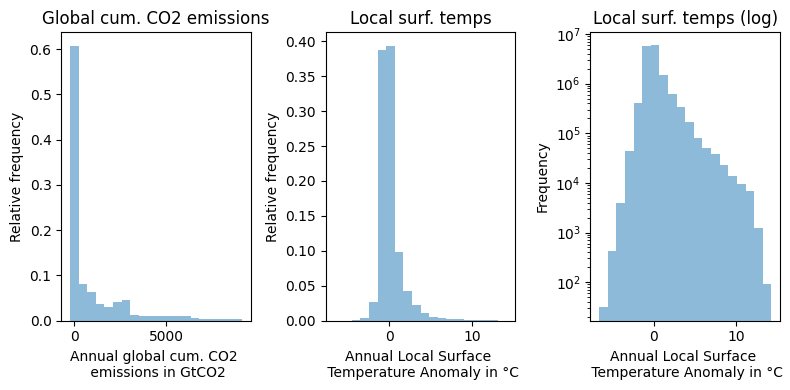

In [64]:
# Initialize an empty array to store the histogram values
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from emcli.data.utils import create_histogram

fig, axs = plt.subplots(1,3, figsize =(8, 4))
# Get CO2 emissions histogram
n_bins = 20
hist, bin_values = create_histogram(data=X_train, var_key='CO2', n_bins=n_bins)
axs[0] = plot_histogram(hist, bin_values, 
        xlabel="Annual global cum. CO2 \n emissions in GtCO2",
        ylabel="Relative frequency",
        title="Global cum. CO2 emissions",
        ax=axs[0])
# Get local temperatures histogram
n_bins = 20
hist, bin_values = create_histogram(data=Y_train, var_key='tas', n_bins=n_bins)
axs[1] = plot_histogram(hist, bin_values, 
        xlabel="Annual Local Surface \n Temperature Anomaly in °C",
        ylabel="Relative frequency",
        title="Local surf. temps",
        ax=axs[1])

# Get log-scale local temperatures histogram
n_bins = 20
hist, bin_values = create_histogram(data=Y_train, var_key='tas', n_bins=n_bins, normalize=False)
axs[2] = plot_histogram(hist, bin_values, 
        xlabel="Annual Local Surface \n Temperature Anomaly in °C",
        ylabel="Frequency",
        title="Local surf. temps (log)",
        ax=axs[2])
axs[2].set_yscale('log')

plt.tight_layout()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1397.08it/s]


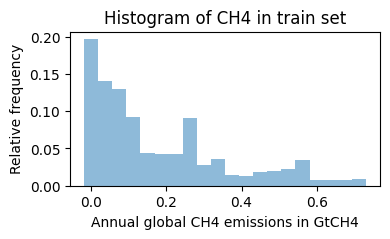

In [166]:
n_bins = 20
hist, bin_values = create_histogram(data=X_train, var_key='CH4', n_bins=n_bins)
ax = plot_histogram(hist, bin_values, 
        xlabel="Annual global CH4 emissions in GtCH4",
        ylabel="Relative frequency",
        title="Histogram of CH4 in train set")

### Could I map co2 onto temperature by eye?

- Mapping annual global CO2 to annual tas by eye is impossible due to internal variability of the model 
    - => There's little value in learning a time-instant mapping from annual global CO2 concentrations to annual locally resolved tas.
- Are the any multi-year trends that the model could learn to predict in an autoregressive mapping?

In [10]:
import hvplot.xarray
import panel.widgets as pnw
# hvplot.extension('bokeh')
scenario_id = 1
clim = (Y_train[scenario_id]['tas'].data.min(),Y_train[scenario_id]['tas'].data.max())
Y_train[scenario_id]['tas'].interactive.sel(time=pnw.DiscreteSlider).hvplot(cmap='viridis', clim=clim, coastline=True)

In [11]:
""" Interactive geospatial plot
import hvplot.xarray
import panel.widgets as pnw
import cartopy.crs as crs
# src: https://hvplot.holoviz.org/

tas.interactive.sel(time=pnw.DiscreteSlider).hvplot.quadmesh(
    'longitude', 'latitude', projection=crs.Mollweide(),# project=True,
    cmap='viridis', coastline=True # global_extent=True, 
)
"""

" Interactive geospatial plot\nimport hvplot.xarray\nimport panel.widgets as pnw\nimport cartopy.crs as crs\n# src: https://hvplot.holoviz.org/\n\ntas.interactive.sel(time=pnw.DiscreteSlider).hvplot.quadmesh(\n    'longitude', 'latitude', projection=crs.Mollweide(),# project=True,\n    cmap='viridis', coastline=True # global_extent=True, \n)\n"

### Does global temp. correlate linearly with local temperature?

In [185]:
scenario_id = 1 # 1: ssp370
n_t = Y_train[scenario_id].time.size
n_lat = Y_train[scenario_id].latitude.size
n_lon = Y_train[scenario_id].longitude.size

# Retrieve annual local temperature field
tas_local = Y_train[scenario_id]['tas'].data
# Retrieve global temperatures
tas_global = Y_train[scenario_id]['tas'].mean(axis=(1,2)).data # spatial average

tas_global.shape, tas_local.shape

((251,), (251, 96, 144))

In [186]:
from sklearn.linear_model import LinearRegression

def fit_globally_linear(tas_global, tas_local):
    """
    Fits a linear model from global temperatures to local 
    temperatures, independent of location. This model will
    ignore all spatial patterns.
    Args:
        tas_global np.array((n_t,))
        tas_local np.array((n_t,n_lat,n_lon))
    Returns:
        preds np.array((n_t, n_lat, n_lon))
    """
    # Process data for linear regression
    ## Repeat global temperature onto locally-resolved grid 
    tas_global = np.tile(tas_global[:,np.newaxis, np.newaxis], reps=(1,n_lat,n_lon)) 
    ## Flatten both arrays
    tas_local = tas_local.flatten()[:,np.newaxis]
    tas_global = tas_global.flatten()[:,np.newaxis]

    # Initialize and fit a LinearRegression model
    model = LinearRegression()
    model.fit(tas_global, tas_local)

    # Make predictions
    preds = model.predict(tas_global)

    # Postprocess data: Reshape onto locally-resovled grid
    preds = preds.reshape((n_t, n_lat, n_lon))
    
    return preds

preds_global_lin = fit_globally_linear(tas_global, tas_local)
preds_global_lin.shape

(251, 96, 144)

In [187]:
## Pattern scaling
def fit_pattern_scale(tas_global, tas_local):
    """
    Does pattern scaling. Here we fit one linear model per 
    grid point. The linear model maps global temperature 
    to the grid point's local temperature. This model captures
    local spatial patterns. The model will be independent
    of neighboring grid points and assumes no non-linearly
    amplifying feedbacks between global temp and local temps.

    Args:
        tas_global np.array((n_t,))
        tas_local np.array((n_t,n_lat,n_lon))
    Returns:
        preds np.array((n_t, n_lat, n_lon))
    """
    # Preprocess data, by flattening in space
    tas_local = tas_local.reshape(n_t,-1) # (n_t, n_lat*n_lon)

    # Fit linear regression coefficients to every grid point
    coeffs = np.polyfit(tas_global, tas_local, deg=1) # (2, n_lat*n_lon)

    # Predict by applying pattern scaling coefficients on locally-resolved grid
    coeffs = coeffs.reshape(-1, n_lat, n_lon) # (2, n_lat, n_lon)
    tas_global = np.tile(tas_global[:,np.newaxis, np.newaxis], reps=(1,n_lat,n_lon)) # repeat onto local grid to be: (n_t, n_lat, n_lon)
    preds = np.polyval(coeffs, tas_global) # (n_t, n_lat, n_lon)
    
    return preds
preds_pattern_scaling = fit_pattern_scale(tas_global, tas_local)
preds_pattern_scaling.shape


(251, 96, 144)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


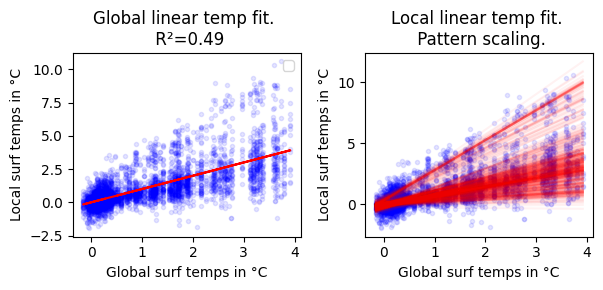

In [207]:
# Evaluate  model performance
# Calculate metrics, e.g., R-square
# r2 = model_global_lin.score(preds_global_lin, tas_local)


fig, axs = plt.subplots(1,2, figsize =(6,3))
# Plot globally linear model
# preprocess data for eval 
tas_global_cp = np.tile(tas_global[:,np.newaxis, np.newaxis], reps=(1,n_lat,n_lon))
tas_global_cp = tas_global_cp.flatten()[:,np.newaxis]
tas_local_cp = tas_local.flatten()[:,np.newaxis]
preds_global_lin_cp = preds_global_lin.flatten()[:,np.newaxis]
# Plot only a subsample
n_subsample = 5000
indices = np.arange(n_t*n_lat*n_lon)
indices_subsample = np.random.choice(indices, size=n_subsample, replace=False)
# Plot data
axs[0].scatter(tas_global_cp[indices_subsample], tas_local_cp[indices_subsample], c='blue', marker='.',alpha=0.1)
axs[0].plot(tas_global_cp[indices_subsample], preds_global_lin_cp[indices_subsample], c='red', linestyle='-')
axs[0].set_xlabel("Global surf temps in °C")
axs[0].set_ylabel("Local surf temps in °C")
axs[0].set_title(f"Global linear temp fit. \n R²={r2:0.2f}")
axs[0].legend()

# Plot pattern scale model
preds_pattern_scaling_cp = preds_pattern_scaling.reshape((n_t,-1))
tas_global_cp2 = np.tile(tas_global[:,np.newaxis, np.newaxis], reps=(1,n_lat,n_lon))
tas_global_cp2 = tas_global_cp2.reshape((n_t,-1))
# plot subsample
indices = np.arange(n_lat*n_lon)
indices_pattern_scale = np.random.choice(indices, size=500, replace=False)
axs[1].scatter(tas_global_cp[indices_subsample], tas_local_cp[indices_subsample], c='blue', marker='.',alpha=0.1)
axs[1].plot(tas_global_cp2[:,indices_pattern_scale], preds_pattern_scaling_cp[:,indices_pattern_scale], c='red', linestyle='-', alpha=0.05)
axs[1].set_xlabel("Global surf temps in °C")
axs[1].set_ylabel("Local surf temps in °C")
axs[1].set_title(f"Local linear temp fit. \n Pattern scaling.")
plt.tight_layout()

